<a href="https://colab.research.google.com/github/DhrubaAdhikary/VisualQualityInspection/blob/master/CS_2dataexploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check if the code is running in a Google Colab environment
try:
    # Attempt to import the Google Colab library
    from google.colab import drive

    print("Google Colab environment detected. Mounting Google Drive...")

    # Mount the Google Drive at the specified path
    drive.mount('/content/drive/')

    print("Google Drive mounted successfully at /content/drive/")

except ImportError:
    # If the import fails, it means the code is not running in Colab
    print("Not a Google Colab environment. Skipping Google Drive mount.")
    # You can add alternative code here for local execution if needed
    pass

Google Colab environment detected. Mounting Google Drive...
Mounted at /content/drive/
Google Drive mounted successfully at /content/drive/


In [4]:

if 'DATALAB_BACKEND_VERSION' in os.environ:
  print('Running on DataLab')
else:
  print('Not running on DataLab')

Not running on DataLab


In [6]:
from zipfile import ZipFile
import os

file_name='/content/drive/MyDrive/severstal-steel-defect-detection.zip'
with ZipFile(file_name,'r') as Zip:
  Zip.extractall()


In [7]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sb
import os

In [8]:
df=pd.read_csv('train.csv')
df.head(2)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...


#### BINARY CLASSIFICATION

In [9]:
defect_img=df.ImageId.unique().tolist()

In [10]:
bin_data=[]
for i in os.listdir('train_images'):
  if i not in bin_data:#Not to duplicate image
    if i in defect_img:
      bin_data.append(['train_images/'+i,1])
    else:
      bin_data.append(['train_images/'+i,0])

In [11]:
bin_label=pd.DataFrame(list(map(lambda x:x[0],bin_data)),columns=['ImageId'])
has_defect=pd.DataFrame(list(map(lambda x:x[1],bin_data)),columns=['has_defect'])

In [12]:
binary_label_pd=pd.concat([bin_label,has_defect],axis=1)

In [13]:
binary_label_pd.head()

,ImageId,has_defect
0,train_images/8ab887d08.jpg,0
1,train_images/fd8e2675c.jpg,0
2,train_images/66a7b82b6.jpg,1
3,train_images/a5f996baa.jpg,1
4,train_images/4a80680e5.jpg,0


#### MULTI LABEL CLASSIFICATION

In [14]:
multi_data=[]
for i in df.ImageId.unique():
  z=np.zeros(4)
  for j in df[df.ImageId==i].ClassId.tolist():
    z[j-1]=1
  op=[]
  p=df[df.ImageId==i].ClassId.tolist()
  #This done just for stratified sampling
  if len(p)==1:
    op.append(p[0])
  else:
    op.append(5)

  multi_data.append(['train_images/'+i,z.tolist(),op])

In [15]:
multi_label=pd.DataFrame(list(map(lambda x:x[0],multi_data)),columns=['ImageId'])
defect_type=pd.DataFrame(list(map(lambda x:x[1],multi_data)),columns=['has_defect_1','has_defect_2','has_defect_3','has_defect_4'])

In [16]:
multi_label_pd=pd.concat([multi_label,defect_type],axis=1)

In [17]:
multi_label_pd['ImageLabel']=list(map(lambda x:x[2][0],multi_data))

In [18]:
multi_label_pd.head()

,ImageId,has_defect_1,has_defect_2,has_defect_3,has_defect_4,ImageLabel
0,train_images/0002cc93b.jpg,1.0,0.0,0.0,0.0,1
1,train_images/0007a71bf.jpg,0.0,0.0,1.0,0.0,3
2,train_images/000a4bcdd.jpg,1.0,0.0,0.0,0.0,1
3,train_images/000f6bf48.jpg,0.0,0.0,0.0,1.0,4
4,train_images/0014fce06.jpg,0.0,0.0,1.0,0.0,3


#### FUNCTION FOR CONVERSION

In [19]:
def rle2mask(mask_rle, shape=(1600,256)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1])
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def rle_mask_resize(rle):
    #convert image into 256,800
    if (pd.isnull(rle))|(rle==''):
        return np.zeros((256,800) ,dtype=np.uint8)

    a=cv2.resize(rle2mask(rle),(800,256))
    return a
def sum_enc(i):
    return sum([int(k) for k in i.split(' ')[1::2]])

## sum_enc_1

In [20]:
data=df

/tmp/ipython-input-21-279499007.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(se1)


<Axes: xlabel='sum_enc_1', ylabel='Density'>

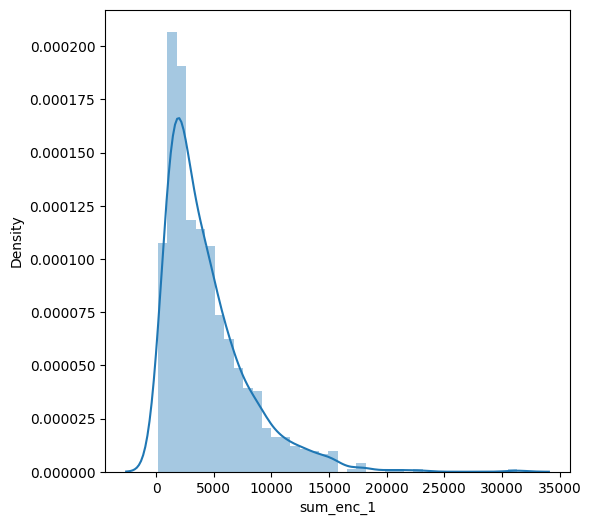

In [21]:
sum_enc_1=[]
for i in range(data.shape[0]):
  if data['ClassId'][i]==1:
    a=data['EncodedPixels'][i].split(' ')[1::2]
    c=0
    for j in a:
      c=c+int(j)
    sum_enc_1.append(c)
  else:
    sum_enc_1.append(0)
data['sum_enc_1']=sum_enc_1
se1=data[data['sum_enc_1']!=0].sum_enc_1
#ploting
plt.figure(figsize=(6,6))
sb.distplot(se1)

In [22]:
for i in range(0,100,10):
    s = np.sort(se1,axis = None)
    print("{} percentile value is {}".format(i,s[int(len(s)*(float(i)/100))]))
print("100 percentile value is ",s[-1])

0 percentile value is 163
10 percentile value is 1061
20 percentile value is 1539
30 percentile value is 2059
40 percentile value is 2574
50 percentile value is 3326
60 percentile value is 4205
70 percentile value is 5196
80 percentile value is 6687
90 percentile value is 9000
100 percentile value is  31303


In [23]:
for i in range(90,100):
    s = np.sort(se1,axis = None)
    print("{} percentile value is {}".format(i,s[int(len(s)*(float(i)/100))]))
print("100 percentile value is ",s[-1])

90 percentile value is 9000
91 percentile value is 9483
92 percentile value is 9832
93 percentile value is 10345
94 percentile value is 11022
95 percentile value is 11650
96 percentile value is 12470
97 percentile value is 13327
98 percentile value is 14529
99 percentile value is 15689
100 percentile value is  31303


In [24]:
for i in np.arange(0.0, 1.0, 0.1):
    s = np.sort(se1,axis = None)
    print("{} percentile value is {}".format(99+i,s[int(len(s)*(float(99+i)/100))]))
print("100 percentile value is ",s[-1])

99.0 percentile value is 15689
99.1 percentile value is 15689
99.2 percentile value is 17050
99.3 percentile value is 17868
99.4 percentile value is 17946
99.5 percentile value is 17983
99.6 percentile value is 19997
99.7 percentile value is 21319
99.8 percentile value is 22844
99.9 percentile value is 31303
100 percentile value is  31303


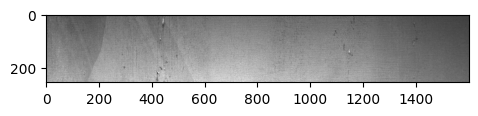

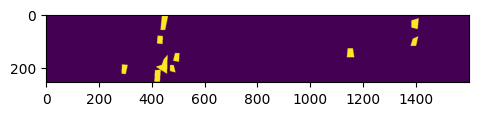

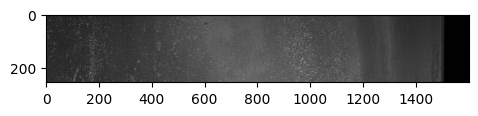

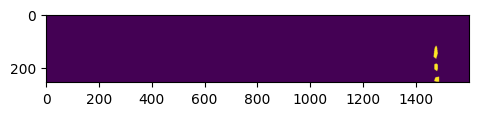

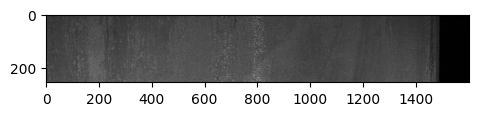

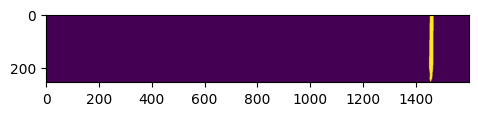

In [25]:
c=40
for i in range(1,7):
  plt.figure(figsize=(12,12))
  if i%2==0:
    c=c+1
    plt.subplot(3, 2, i)
    plt.imshow(rle2mask(data[data.ClassId==1].iloc[c,:].values[2]))
  else:
    plt.subplot(3, 2, i)
    plt.imshow(cv2.imread('train_images/'+data[data.ClassId==1].iloc[c+1,:].values[0]))


#### OBSERVATION
1. In class 1, the sum of encoding start from 163
2. We can observe that after 17983 there is a sudden increase for 2k.

## sum_enc_2

In [26]:
sum_enc_2=[]
for i in range(data.shape[0]):
  if data['ClassId'][i]==2:
    a=data['EncodedPixels'][i].split(' ')[1::2]
    c=0
    for j in a:
      c=c+int(j)
    sum_enc_2.append(c)
  else:
    sum_enc_2.append(0)
data['sum_enc_2']=sum_enc_2

In [27]:
se2=data[data['sum_enc_2']!=0].sum_enc_2

/tmp/ipython-input-28-1891804483.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(se2)


<Axes: xlabel='sum_enc_2', ylabel='Density'>

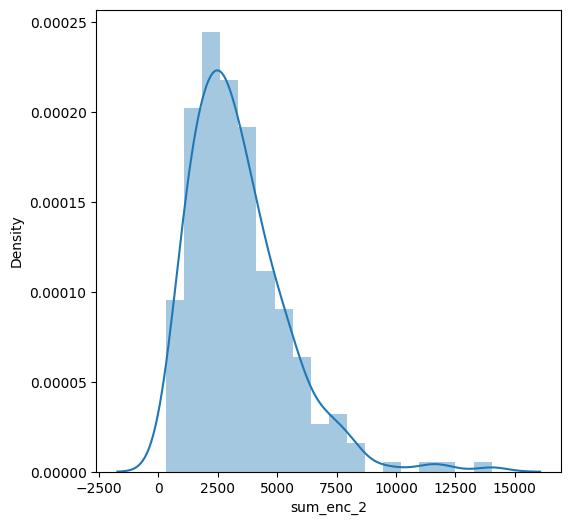

In [28]:
plt.figure(figsize=(6,6))
sb.distplot(se2)

In [29]:
for i in range(0,100,10):
    s = np.sort(se2,axis = None)
    print("{} percentile value is {}".format(i,s[int(len(s)*(float(i)/100))]))
print("100 percentile value is ",s[-1])

0 percentile value is 316
10 percentile value is 1209
20 percentile value is 1635
30 percentile value is 2172
40 percentile value is 2583
50 percentile value is 2944
60 percentile value is 3448
70 percentile value is 3989
80 percentile value is 4774
90 percentile value is 5914
100 percentile value is  14023


In [30]:
for i in range(90,100):
    s = np.sort(se2,axis = None)
    print("{} percentile value is {}".format(i,s[int(len(s)*(float(i)/100))]))
print("100 percentile value is ",s[-1])

90 percentile value is 5914
91 percentile value is 5945
92 percentile value is 6342
93 percentile value is 6672
94 percentile value is 7001
95 percentile value is 7196
96 percentile value is 7552
97 percentile value is 7885
98 percentile value is 8309
99 percentile value is 11302
100 percentile value is  14023


In [31]:
for i in np.arange(0.0, 1.0, 0.1):
    s = np.sort(se2,axis = None)
    print("{} percentile value is {}".format(99+i,s[int(len(s)*(float(99+i)/100))]))
print("100 percentile value is ",s[-1])

99.0 percentile value is 11302
99.1 percentile value is 11302
99.2 percentile value is 11973
99.3 percentile value is 11973
99.4 percentile value is 11973
99.5 percentile value is 11973
99.6 percentile value is 14023
99.7 percentile value is 14023
99.8 percentile value is 14023
99.9 percentile value is 14023
100 percentile value is  14023


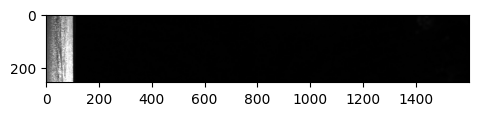

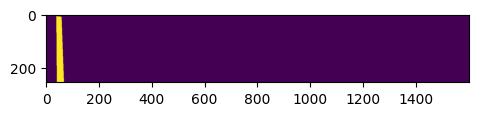

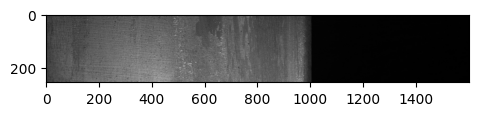

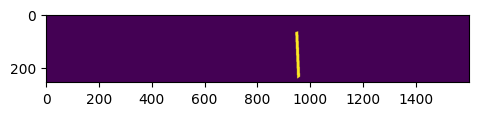

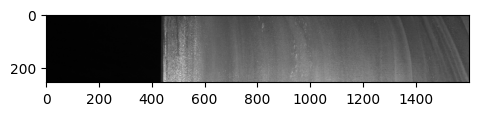

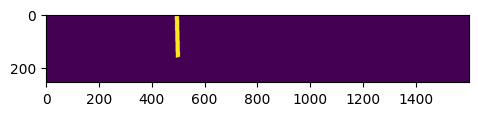

In [32]:
c=4
for i in range(1,7):
  plt.figure(figsize=(12,12))
  if i%2==0:
    c=c+1
    plt.subplot(3, 2, i)
    plt.imshow(rle2mask(data[data.ClassId==2].iloc[c,:].values[2]))
  else:
    plt.subplot(3, 2, i)
    plt.imshow(cv2.imread('train_images/'+data[data.ClassId==2].iloc[c+1,:].values[0]))


#### OBSERVATION
1. In class 2, the sum of encoding start from 316
2. We can observe that after 8163 there is a sudden increase for 2k(approx).

## sum_enc_3

In [33]:
sum_enc_3=[]
for i in range(data.shape[0]):
  if data['ClassId'][i]==3:
    a=data['EncodedPixels'][i].split(' ')[1::2]
    c=0
    for j in a:
      c=c+int(j)
    sum_enc_3.append(c)
  else:
    sum_enc_3.append(0)
data['sum_enc_3']=sum_enc_3

/tmp/ipython-input-34-3192473886.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(se3)


<Axes: xlabel='sum_enc_3', ylabel='Density'>

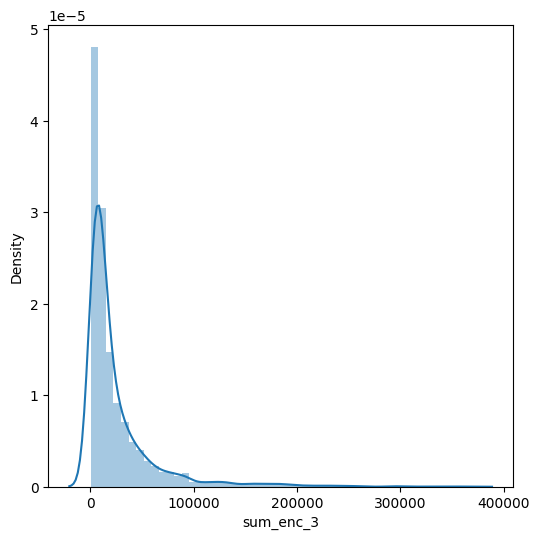

In [34]:
se3=data[data['sum_enc_3']!=0].sum_enc_3
plt.figure(figsize=(6,6))
sb.distplot(se3)

In [35]:
for i in range(0,100,10):
    s = np.sort(se3,axis = None)
    print("{} percentile value is {}".format(i,s[int(len(s)*(float(i)/100))]))
print("100 percentile value is ",s[-1])

0 percentile value is 115
10 percentile value is 2787
20 percentile value is 4280
30 percentile value is 5939
40 percentile value is 8746
50 percentile value is 11960
60 percentile value is 15971
70 percentile value is 23425
80 percentile value is 35928
90 percentile value is 62034
100 percentile value is  368240


In [36]:
for i in range(90,100):
    s = np.sort(se3,axis = None)
    print("{} percentile value is {}".format(i,s[int(len(s)*(float(i)/100))]))
print("100 percentile value is ",s[-1])

90 percentile value is 62034
91 percentile value is 67053
92 percentile value is 73230
93 percentile value is 79583
94 percentile value is 87117
95 percentile value is 94089
96 percentile value is 112542
97 percentile value is 131715
98 percentile value is 160856
99 percentile value is 193938
100 percentile value is  368240


In [37]:
for i in np.arange(0.0, 1.0, 0.1):
    s = np.sort(se3,axis = None)
    print("{} percentile value is {}".format(99+i,s[int(len(s)*(float(99+i)/100))]))
print("100 percentile value is ",s[-1])

99.0 percentile value is 193938
99.1 percentile value is 198285
99.2 percentile value is 207701
99.3 percentile value is 211788
99.4 percentile value is 227070
99.5 percentile value is 232238
99.6 percentile value is 243166
99.7 percentile value is 252123
99.8 percentile value is 289556
99.9 percentile value is 316414
100 percentile value is  368240


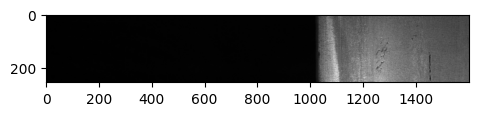

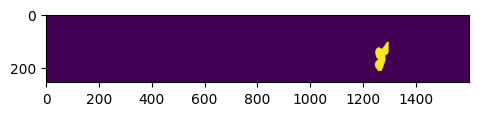

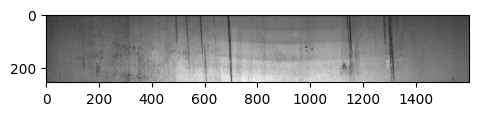

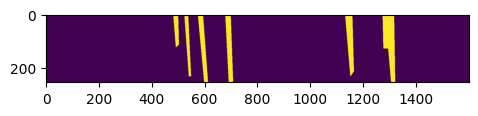

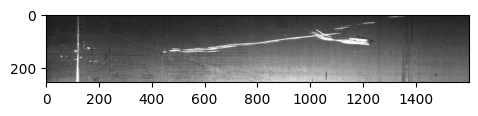

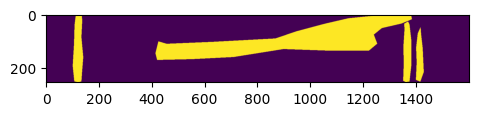

In [38]:
c=4
for i in range(1,7):
  plt.figure(figsize=(12,12))
  if i%2==0:
    c=c+1
    plt.subplot(3, 2, i)
    plt.imshow(rle2mask(data[data.ClassId==3].iloc[c,:].values[2]))
  else:
    plt.subplot(3, 2, i)
    plt.imshow(cv2.imread('train_images/'+data[data.ClassId==3].iloc[c+1,:].values[0]))


#### OBSERVATION
1. The plot is very skewed. Which means there are only some images whose sum_encoding is greater than 100k.
2. In class 3, the sum of encoding start from 115
3. We can observe that after 162877 there is a sudden increase for 3k(approx).

## sum_enc_4

In [39]:
sum_enc_4=[]
for i in range(data.shape[0]):
  if data['ClassId'][i]==4:
    a=data['EncodedPixels'][i].split(' ')[1::2]
    c=0
    for j in a:
      c=c+int(j)
    sum_enc_4.append(c)
  else:
    sum_enc_4.append(0)
data['sum_enc_4']=sum_enc_4

/tmp/ipython-input-40-1571148495.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(se4)


<Axes: xlabel='sum_enc_4', ylabel='Density'>

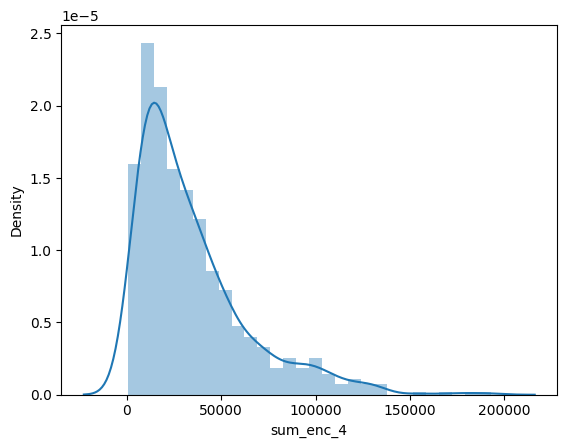

In [40]:
se4=data[data['sum_enc_4']!=0].sum_enc_4
sb.distplot(se4)

In [41]:
for i in range(0,100,10):
    s = np.sort(se4,axis = None)
    print("{} percentile value is {}".format(i,s[int(len(s)*(float(i)/100))]))
print("100 percentile value is ",s[-1])

0 percentile value is 491
10 percentile value is 7090
20 percentile value is 11270
30 percentile value is 14671
40 percentile value is 19844
50 percentile value is 25357
60 percentile value is 32663
70 percentile value is 40546
80 percentile value is 52412
90 percentile value is 75187
100 percentile value is  192780


In [42]:
for i in range(90,100):
    s = np.sort(se4,axis = None)
    print("{} percentile value is {}".format(i,s[int(len(s)*(float(i)/100))]))
print("100 percentile value is ",s[-1])

90 percentile value is 75187
91 percentile value is 80525
92 percentile value is 84157
93 percentile value is 88861
94 percentile value is 93957
95 percentile value is 98530
96 percentile value is 101415
97 percentile value is 108784
98 percentile value is 119340
99 percentile value is 129924
100 percentile value is  192780


In [43]:
for i in np.arange(0.0, 1.0, 0.1):
    s = np.sort(se4,axis = None)
    print("{} percentile value is {}".format(99+i,s[int(len(s)*(float(99+i)/100))]))
print("100 percentile value is ",s[-1])

99.0 percentile value is 129924
99.1 percentile value is 131875
99.2 percentile value is 133065
99.3 percentile value is 133656
99.4 percentile value is 134071
99.5 percentile value is 134071
99.6 percentile value is 154818
99.7 percentile value is 171949
99.8 percentile value is 182380
99.9 percentile value is 192780
100 percentile value is  192780


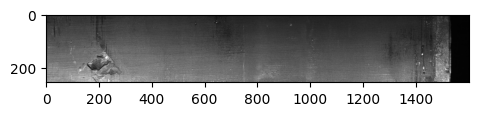

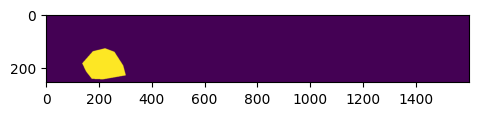

In [ ]:
c=4
for i in range(1,7):
  plt.figure(figsize=(12,12))
  if i%2==0:
    c=c+1
    plt.subplot(3, 2, i)
    plt.imshow(rle2mask(data[data.ClassId==4].iloc[c,:].values[2]))
  else:
    plt.subplot(3, 2, i)
    plt.imshow(cv2.imread('train_images/'+data[data.ClassId==4].iloc[c+1,:].values[0]))



#### OBSERVATION
1. The plot is skewed.
2. In class 4, the sum of encoding starts from 491.
3. We can set a threshold of 13k.

In [ ]:
data.shape

### CLASS DISTRIBUTION

In [ ]:
sb.countplot(x='has_defect',data=binary_label_pd)

#### OBSERVATION
1. data is some how look like balance.

In [ ]:
plt.figure(figsize=(7,4))
sb.countplot(x='ImageLabel',data=multi_label_pd[multi_label_pd.ImageLabel!=0])
label=['1st class','2nd class','3rd class','4th class','multi label class']
index=[0,1,2,3,4]
plt.title('Class distribution for data')
plt.xticks(index,label)

#### OBSERVATION
1. Data is very unbalanced. In the dataset, 3rd class defect is much more than the others.
2. Due to unbalance data we cannot much rely on accuracy metric.
